In [1]:
 """ Compute redness indices on individual color copepod images 

Usage:
======
    1. Read all files and write pixel size and pixel numer by image [X]
    2. Intercalibrate images and save them - print 32 images randomly [X]
    3. Define color deconvolution matrix [X]
    4. Deconvolution of astaxanthin redness [X]
    5. Normalise astaxanthin redness between 0 and 1 and save the one dimension image - print the same 32 images than before [X]
    6. Use a threshold to define red pixels, sum optical density levels by image, devide by the pixel_nb*pixelarea [X]
    7. Save a tible with image name associated to the redness index [X]
     
"""

__authors__ = ("Laure Vilgrain", "Jean-Olivier Irisson", "Simon-Martin Schröder")
__contact__ = ("laure.vilgrain@imev-mer.fr", "irisson@normalesup.org", "sms@informatik.uni-kiel.de")
__version__ = "1.0.0"
__date__ = "04-2021" 

In [1]:
import pandas as pd
import numpy as np
import csv
import xarray as xr
import os
import statistics as stat
from matplotlib import pyplot as plt
import copy
import random
import pickle
import sys
import time
import gc

from skimage.io import imread
from skimage.color.colorconv import separate_stains, gray_from_rgb, yuv_from_rgb, yiq_from_rgb, rgb_from_hed, hed_from_rgb
from scipy import linalg
from skimage import io, data, color, exposure, feature, morphology, measure
from scipy import ndimage as ndi
from skimage.filters import threshold_otsu
from matplotlib.colors import hex2color, rgb2hex
import colour
from colour.plotting import plot_single_colour_swatch, ColourSwatch

## 1. Read images and save pixel information

### Save RGB infos

In [12]:
# TODO : understand why this is not working
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [17]:
# TODO : check if we can optimize this because it is really long
imgs_names = os.listdir("../imgs_dataset/1.Original/") # all images to read
imgs_names.sort() # sort images to visualize them in the same order
original_RGB = []
RGB_median_list = [] # prepare a list to save median RGB values of images
size_list = []

# DO: add a condition on file types to read (.tiff, .jpg)
valid_extensions = [".tif", ".tiff", ".jpg", ".jpeg", ".png"]
imgs_names = [img for img in imgs_names if any(img.endswith(ext) for ext in valid_extensions)]


#Image analysis 
for i in range(0, len(imgs_names)): 
    filename = "../imgs_dataset/1.Original/" + imgs_names[i]
    img = io.imread(filename)
    RGB_median_list.append(np.median(img))# stock the RGB median values in a list
    original_RGB.append(np.mean(img, axis=(0,1)))# stock the RGB calibrated values in a list

In [18]:
print("Average original RGB value:", np.mean(original_RGB),", standard deviation:", np.std(original_RGB))
print("---")
print("List of RGB medians: ", RGB_median_list) 
#TODO: plot RGB distributions in histograms 

Average original RGB value: 172.311636501 , standard deviation: 17.6383846957
---
List of RGB medians:  [183.0, 177.0, 183.0, 181.0, 182.0, 182.0, 182.0, 176.0, 182.0, 182.0, 186.0, 175.0, 184.0, 179.0, 183.0, 182.0, 182.0, 186.0, 181.0, 182.0, 181.0, 183.0, 185.0, 184.0, 177.0, 186.0, 187.0, 184.0, 183.0, 182.0, 183.0, 172.0, 182.0, 179.0, 186.0, 180.0, 179.0, 187.0, 188.0, 184.0, 183.0, 176.0, 184.0, 186.0, 185.0, 184.0, 186.0, 185.0, 182.0, 184.0, 186.0, 180.0, 178.0, 184.0, 186.0, 178.0, 183.0, 186.0, 187.0, 180.0, 182.0, 181.0, 185.0, 185.0, 184.0, 180.0, 182.0, 181.0, 181.0, 179.0, 186.0, 182.0, 183.0, 188.0, 188.0, 185.0, 187.0, 186.0, 187.0, 184.0, 186.0, 184.0, 182.0, 185.0, 181.0, 183.0, 185.0, 187.0, 183.0, 184.0, 183.0, 186.0, 183.0, 185.0, 176.0, 178.0, 185.0, 181.0, 179.0, 184.0, 203.0, 201.0, 210.0, 212.0, 213.0, 209.0, 210.0, 207.0, 208.0, 208.0, 205.0, 206.0, 210.0, 207.0, 208.0, 206.0, 211.0, 212.0, 209.0, 203.0, 209.0, 211.0, 207.0, 208.0, 209.0, 208.0, 209.0, 209.0,

### Save pixel information

In [20]:
# Image total size
img_ex = io.imread("../imgs_dataset/1.Original/" + imgs_names[4])
img_length = img_ex.shape[1]
img_pixel_number = img_ex.size

# One pixel length
pixel_2018_mm = 1/456
pixel_2018_um = pixel_2018_mm*1000

pixel_2019_mm = 1/368
pixel_2019_um = pixel_2019_mm*1000

print('the size of one pixel in 2018 is', pixel_2018_mm,'mm =', pixel_2018_um, 'μm')
print('the size of one pixel in 2019 is', pixel_2019_mm,'mm =', pixel_2019_um, 'μm')

# Image total length
print('The total length of one image is', img_length * pixel_2018_mm, 'mm')

the size of one pixel in 2018 is 0.0021929824561403508 mm = 2.1929824561403506 μm
the size of one pixel in 2019 is 0.002717391304347826 mm = 2.717391304347826 μm
The total length of one image is 5.614035087719298 mm


### Visualize

In [21]:
# Print a selection of original images
imgs_sample = random.sample(imgs_names,32)

Original images


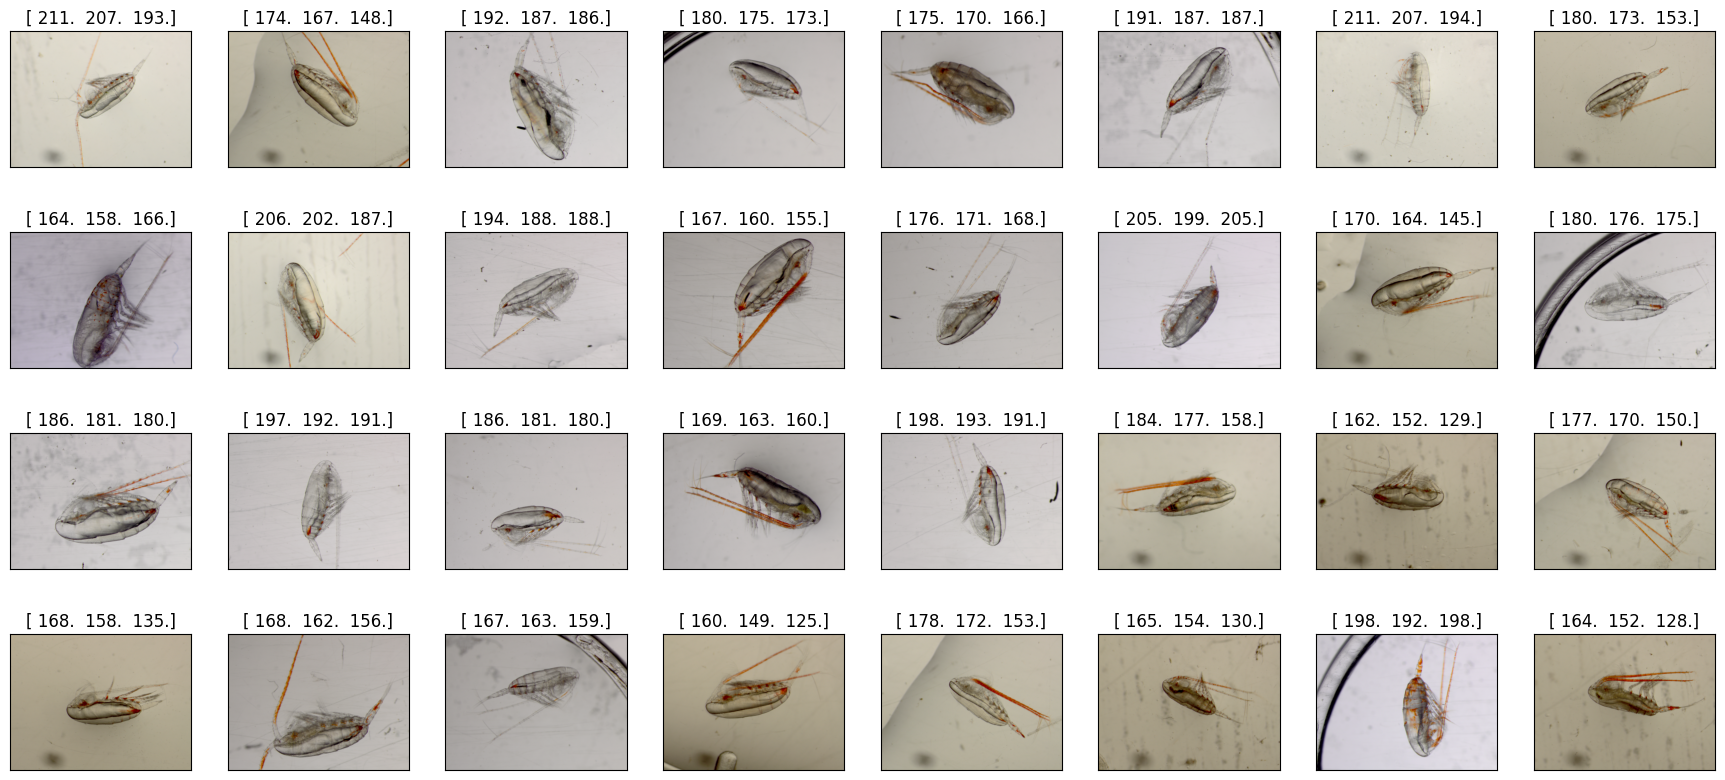

In [22]:
print("Original images")
w = 16
h = 13
fig = plt.figure(figsize=(22, 10))
columns = 8
rows = 4
for i in range(0, columns*rows): # TODO: add a condition on file types to read (.tiff, .jpg)
    filename = "../imgs_dataset/1.Original/" + imgs_sample[i]
    img = io.imread(filename)
    fig.add_subplot(rows, columns, i+1)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title(np.around(np.mean(img, axis=(0,1))))
    plt.imshow(img)
plt.show()

## 2. Intercalibrate images and save

### Intercalibrate and save

In [24]:
# create a folder for calibrated images
folder_calib = "../imgs_dataset/2.Calibrated/"
if not os.path.exists(folder_calib):
    os.makedirs(folder_calib)

In [25]:
final_RGB = [] #list with final images arrays

for i in range(0, len(imgs_names)): 
    filename = "../imgs_dataset/1.Original/" + imgs_names[i]
    img = io.imread(filename)
    # compute median intensity per channel
    med_r = np.median(img[:,:,0])
    med_g = np.median(img[:,:,1])
    med_b = np.median(img[:,:,2])
    
    # convert all channels to have similar average intensities on the original image and between images
    img_calib = copy.copy(img)
    img_calib[:,:,0] = np.minimum(img[:,:,0] / med_r * np.mean(RGB_median_list), 255)
    img_calib[:,:,1] = np.minimum(img[:,:,1] / med_g * np.mean(RGB_median_list), 255)
    img_calib[:,:,2] = np.minimum(img[:,:,2] / med_b * np.mean(RGB_median_list), 255)
    final_RGB.append(np.mean(img_calib, axis=(0,1))) # stock the RGB calibrated values in a list
    # NB: check that this stays in [0,255] = [black, white]
    io.imsave("../imgs_dataset/2.Calibrated/" + imgs_names[i], img_calib)

### Visualize

Calibrated images


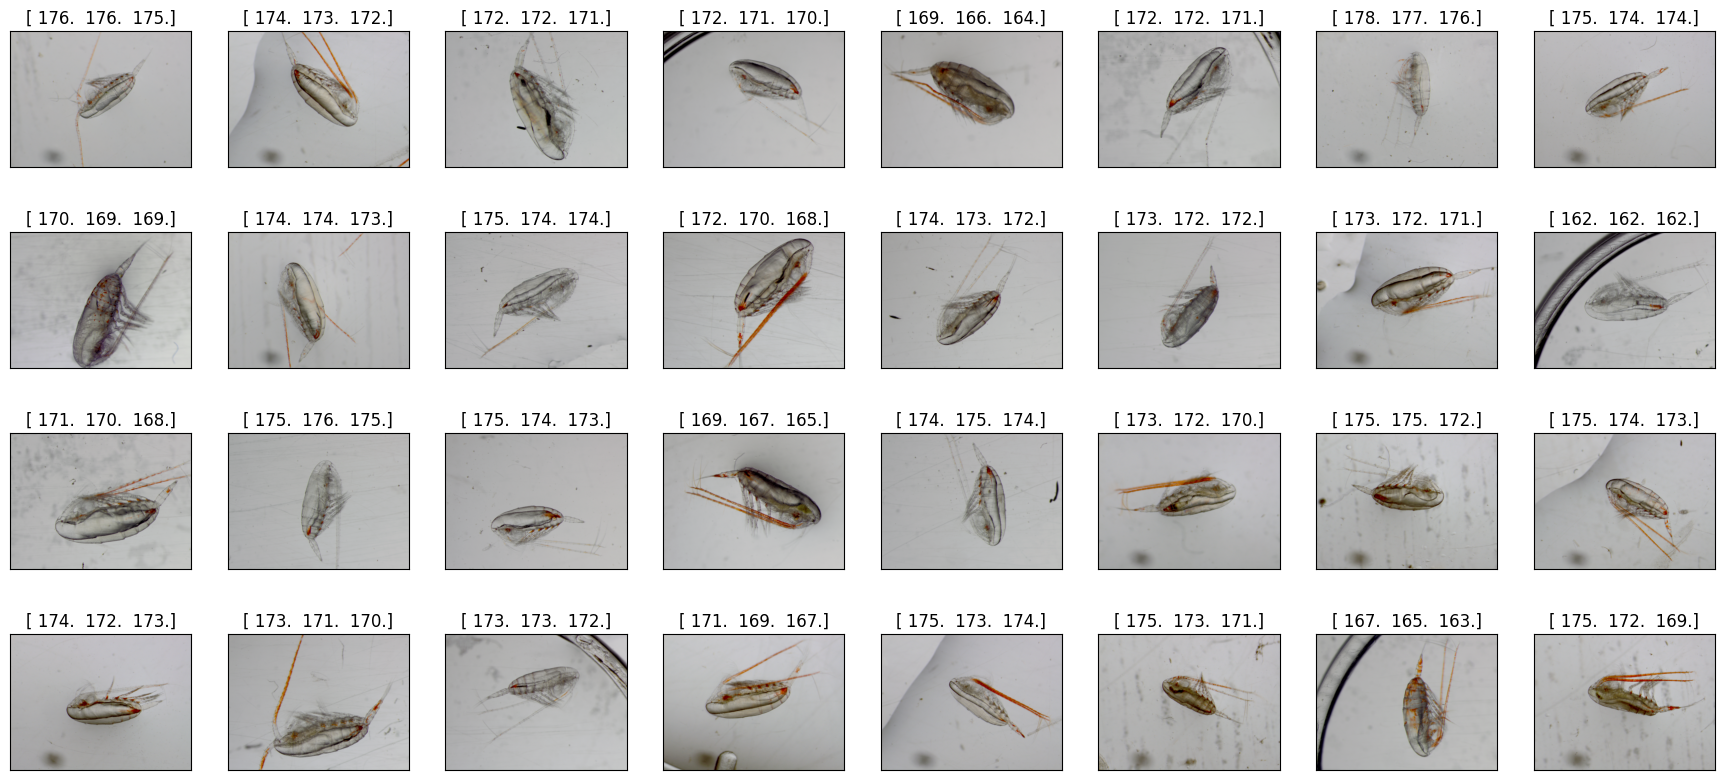

Average final RGB value: 171.857360255 , standard deviation: 3.43230237014


In [26]:
print("Calibrated images")
w = 16
h = 13
fig = plt.figure(figsize=(22, 10))
columns = 8
rows = 4
for i in range(0, columns*rows): # TODO: add a condition on file types to read (.tiff, .jpg)
    filename = "../imgs_dataset/2.Calibrated/" + imgs_sample[i]
    img = io.imread(filename)
    fig.add_subplot(rows, columns, i+1)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title(np.around(np.mean(img, axis=(0,1))))
    plt.imshow(img)
plt.show()
print("Average final RGB value:", np.mean(final_RGB), ", standard deviation:", np.std(final_RGB))

Everything is working well up to this point, but it probably takes a lot of RAM. Might be possible to stop here the calibration part, clear everything and then start again with the deconvolution part. Let's check. 

In [4]:
# list of all objects in the environment
objs = [(var, sys.getsizeof(val)) for var, val in globals().items() if not var.startswith("__")]

# print them within a dataFrame, sorted by decreasing size par 
objects_sizes = pd.DataFrame(objs, columns=['Variable', 'Size (octets)']).sort_values(by='Size (octets)', ascending=False)
objects_sizes


def format_size(size):
    for unit in ['o', 'Ko', 'Mo', 'Go']:
        if size < 1024:
            return f"{size:.1f} {unit}"
        size /= 1024
    return f"{size:.1f} To"

objects_sizes['Readable size'] = objects_sizes['Size (octets)'].apply(format_size)
#pd.set_option('display.max_rows', None)
#pd.reset_option('display.max_rows')
objects_sizes[['Variable', 'Readable size']]

Variable Readable size
48               ColourSwatch        1.7 Ko
53                        _i4       766.0 o
13                        _i1       718.0 o
12                       _iii       718.0 o
10                         _i       631.0 o
50                        _i3       631.0 o
49                        _i2       304.0 o
11                        _ii       304.0 o
51            rgb_from_stains       200.0 o
52            stains_from_rgb       200.0 o
33               hed_from_rgb       200.0 o
32               rgb_from_hed       200.0 o
31               yiq_from_rgb       200.0 o
30               yuv_from_rgb       200.0 o
29              gray_from_rgb       200.0 o
47  plot_single_colour_swatch       160.0 o
45                    rgb2hex       160.0 o
44                  hex2color       160.0 o
28            separate_stains       160.0 o
43             threshold_otsu       160.0 o
27                     imread       160.0 o
8                        open       160.0 o
0                         _ih       120.0 o
3                          In       120.0 o
35                         io        72.0 o
46                     colour        72.0 o
14                         pd        72.0 o
42                        ndi        72.0 o
41                    measure        72.0 o
40                 morphology        72.0 o
39                    feature        72.0 o
38                   exposure        72.0 o
22                     random        72.0 o
36                       data        72.0 o
21                       copy        72.0 o
34                     linalg        72.0 o
26                         gc        72.0 o
23                     pickle        72.0 o
24                        sys        72.0 o
25                       time        72.0 o
15                         np        72.0 o
37                      color        72.0 o
20                        plt        72.0 o
19                       stat        72.0 o
18                         os        72.0 o
17                         xr        72.0 o
16                        csv        72.0 o
1                         _oh        64.0 o
5                 get_ipython        64.0 o
4                         Out        64.0 o
2                         _dh        64.0 o
7                        quit        48.0 o
6                        exit        48.0 o
9                           _        41.0 o

In [35]:
# remove img_ex, img, img_calib??
del img
del img_calib
del img_ex

## 3. Define color deconvolution matrix

RGB values associated to astaxanthin absorbtion spectrum are calculated in the script *0. Astaxanthin spectrum to RGB*. This script gives the final value of [ 1 ,0.69690743, 0.64808983], which might be changed if we have a new absorption spectrum for astaxanthin. We put these 3 values into the Optical Density matric hereafter. 


In [5]:
# Optical density (OD) matrix = RGB matrix
rgb_from_stains = np.array([
    # RGB value of astaxanthin from literature 
    [ 1.        ,  0.69690743,  0.64808983],
    # White
    [1, 1, 1],
    # Placeholder for third color
    [0,0,0]])

# Calculate residuals = normalizeq the OD matrix: 
rgb_from_stains[2, :] = np.cross(rgb_from_stains[0, :], rgb_from_stains[1, :])
display("Normalized OD matrix :", rgb_from_stains)

# Calculate matrix inverse with linalg.inv :
stains_from_rgb = linalg.inv(rgb_from_stains)
display("Inversed OD matrix = color deconvolution matrix:", stains_from_rgb)

'Normalized OD matrix :'

array([[ 1.        ,  0.69690743,  0.64808983],
       [ 1.        ,  1.        ,  1.        ],
       [ 0.0488176 , -0.35191017,  0.30309257]])

'Inversed OD matrix = color deconvolution matrix:'

array([[ 3.00337314, -2.01430059,  0.22384253],
       [-1.16592278,  1.24469524, -1.61360783],
       [-1.83745036,  1.76960535,  1.38976531]])

In [ ]:

#??? nothing big at this stage
#del final_RGB 
#del original_RGB
#gc.collect()

## 4. Deconvolution of astaxanthin redness 

### Deconvolute

In [6]:
# Prepare list of calibrated images
imgs_calib_list = os.listdir("../imgs_dataset/2.Calibrated/") # for now, we are taking calibrated images with the first calibration method 
imgs_calib_list.sort() # sort images to visualize them in the same order


# DO: add a condition on file types to read (.tiff, .jpg)
valid_extensions = [".tif", ".tiff", ".jpg", ".jpeg", ".png"]
imgs_calib_list = [img for img in imgs_calib_list if any(img.endswith(ext) for ext in valid_extensions)]


In [7]:
len(imgs_calib_list)
#display(imgs_calib_list)

699

In [8]:
asta_OD_min = []
asta_OD_max = []
asta_OD_imgs_list = []

#crashes here
for i in range(0, len(imgs_calib_list)):
    filename_calibrated = "../imgs_dataset/2.Calibrated/" + imgs_calib_list[i]
    img_calib = io.imread(filename_calibrated)
    stains = separate_stains(img_calib, stains_from_rgb) # Extract stains 
    red = -stains[...,0]# RGB to stain color space conversion (sickit image)
    asta_OD_imgs_list.append(red)
    asta_OD_min.append(np.min(red))
    asta_OD_max.append(np.max(red))
    # free memory
    del img_calib, stains, red
    gc.collect()
    
print(len(asta_OD_imgs_list))

699


In [38]:
with open("/home/lvilgrain/complex/ecoplast_clean_dataset/data/asta_OD_imgs_list.txt", "wb") as OD:   #Pickling
    pickle.dump(asta_OD_imgs_list, OD)

In [10]:
# Prepare list of index of image sample (32 images to print):

# store image_names
imgs_sample = random.sample(imgs_names,32)

index_sample_list = []
for i in imgs_sample:
    index = imgs_calib_list.index(i)
    index_sample_list.append(index)

print(index_sample_list)
len(index_sample_list)
len(imgs_sample)

NameError: name 'imgs_names' is not defined

### Visualize

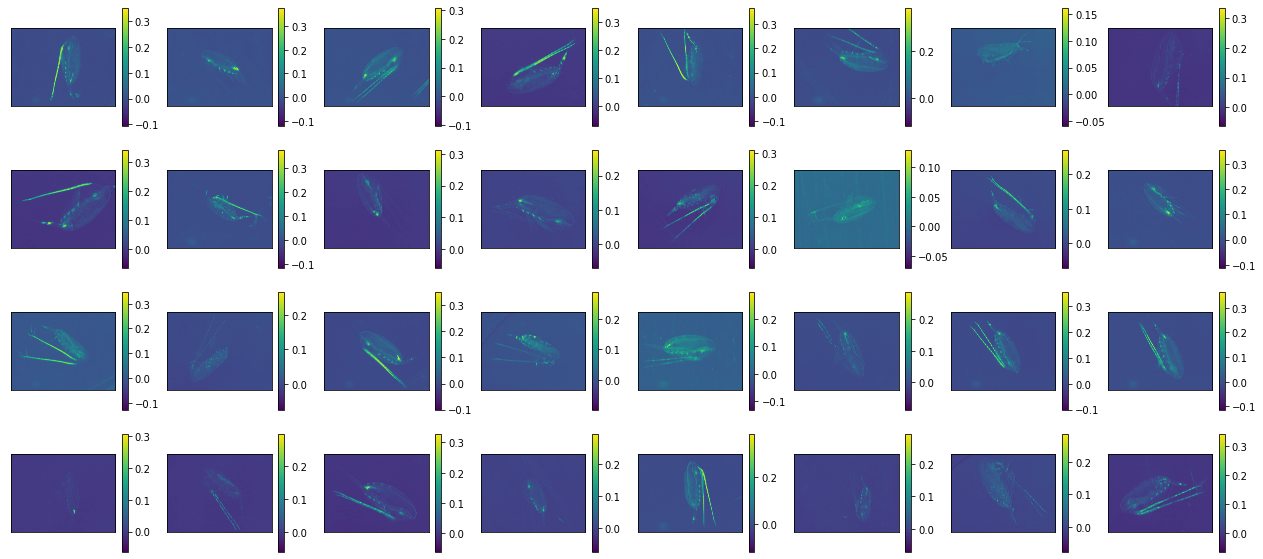

In [21]:
fig = plt.figure(figsize=(22, 10))
columns = 8
rows = 4
j=1
for i in index_sample_list:
    #print(i)
    red = asta_OD_imgs_list[i]
    # Plot
    fig.add_subplot(rows, columns, j)
    #plt.title(imgs_names[i])
    plt.xticks([], [])
    plt.yticks([], [])
    low, high = np.quantile(red, (.0, 1))
    plt.imshow(red, vmin=low, vmax = high)
    plt.colorbar()
    j = j+1
plt.show()

In [22]:
print("min =", np.min(asta_OD_min), ", max =", np.max(asta_OD_max))

min = -0.2259560245494537 , max = 0.4319214852290107


 ## 5. Normalise astaxanthin redness between 0 and 1 and save the one dimension image

### Normalise

In [23]:
imgs_norm_list = [ ]

for i in range(0, len(asta_OD_imgs_list)):
    img = asta_OD_imgs_list[i]
    # threshold using intensities histogramm on the image 
    img_norm = (img + np.absolute(np.min(asta_OD_min))) / (np.max(asta_OD_max) + np.absolute(np.min(asta_OD_min)))
    imgs_norm_list.append(img_norm)
    # io.imsave("/home/lvilgrain/complex/ecoplast_clean_dataset/3.Normalised_OD_levels/" + imgs_names[i], img_norm)
    # how to save it ? 
print(len(imgs_norm_list))


699


### Visualize

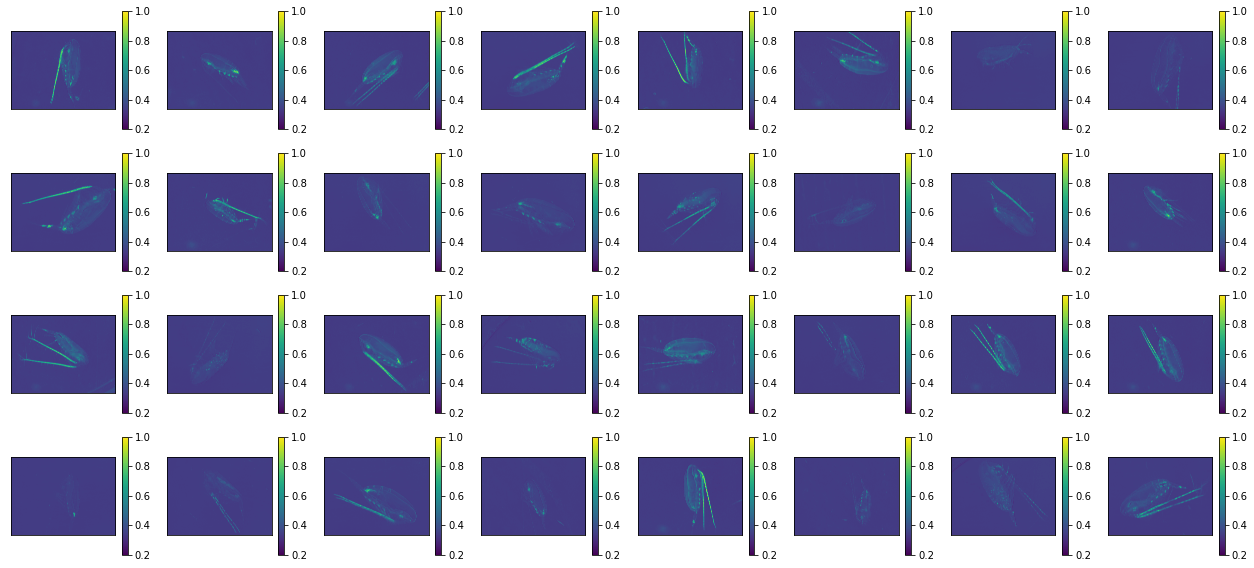

min = 0.0 max = 1.0


In [25]:
fig = plt.figure(figsize=(22, 10))
columns = 8
rows = 4
j=1
for i in index_sample_list:
    #print(i)
    img_norm = imgs_norm_list[i]
    # Plot
    fig.add_subplot(rows, columns, j)
    plt.xticks([], [])
    plt.yticks([], [])
    #low, high = np.quantile(img_norm, (.0, 1))
    plt.imshow(img_norm, vmin=0.2, vmax = 1)
    plt.colorbar()
    j = j+1
plt.show()
print("min =", np.min(imgs_norm_list), "max =", np.max(imgs_norm_list))

In [39]:
#write
#with open("/home/lvilgrain/complex/ecoplast_clean_dataset/data/imgs_norm_list.txt", "wb") as imgnrm:   #Pickling
    #pickle.dump(imgs_norm_list, imgnrm)
    
del imgs_norm_list
gc.collect()

## 6. Thresholding of and sum of redness among pixels

### Threshold and sum of asta OD levels

In [364]:
red_mask_list = []

for i in range(0, len(imgs_norm_list)):
    filename_calibrated = "/home/lvilgrain/complex/ecoplast_clean_dataset/2.Calibrated/" + imgs_calib_list[i]
    img_calib = io.imread(filename_calibrated)
    img_norm = imgs_norm_list[i]
    # Threshold using intensities histogramm on the image 
    thr = 0.45 #base on otsu thresholding
    red_pix = img_norm < thr
    red_mask = img_norm > thr
    red_mask_list.append(red_mask)

    # Distinguish red pixels on orginal image
    img_masked = copy.copy(img_calib)
    img_masked[:,:,0][red_pix] = 255
    img_masked[:,:,1][red_pix] = 255
    img_masked[:,:,2][red_pix] = 255
    io.imsave("/home/lvilgrain/complex/ecoplast_clean_dataset/3.Red_pixels_masked/" + imgs_names[i], img_masked)
    
    img_highlight = copy.copy(img_calib)
    img_highlight[:,:,0][red_mask] = 255
    img_highlight[:,:,1][red_mask] = 255
    img_highlight[:,:,2][red_mask] = 255
    io.imsave("/home/lvilgrain/complex/ecoplast_clean_dataset/4.Red_pixels_highlighted/" + imgs_names[i], img_highlight)

<ipython-input-364-9c2b9da53f79>:18: UserWarning: /home/lvilgrain/complex/ecoplast_clean_dataset/3.Red_pixels_masked/2018_AR_p21_3.tif is a low contrast image
  io.imsave("/home/lvilgrain/complex/ecoplast_clean_dataset/3.Red_pixels_masked/" + imgs_names[i], img_masked)
<ipython-input-364-9c2b9da53f79>:18: UserWarning: /home/lvilgrain/complex/ecoplast_clean_dataset/3.Red_pixels_masked/2018_AR_p21_7.tif is a low contrast image
  io.imsave("/home/lvilgrain/complex/ecoplast_clean_dataset/3.Red_pixels_masked/" + imgs_names[i], img_masked)
<ipython-input-364-9c2b9da53f79>:18: UserWarning: /home/lvilgrain/complex/ecoplast_clean_dataset/3.Red_pixels_masked/2018_AR_p24_1.tif is a low contrast image
  io.imsave("/home/lvilgrain/complex/ecoplast_clean_dataset/3.Red_pixels_masked/" + imgs_names[i], img_masked)
<ipython-input-364-9c2b9da53f79>:18: UserWarning: /home/lvilgrain/complex/ecoplast_clean_dataset/3.Red_pixels_masked/2018_AR_p24_10.tif is a low contrast image
  io.imsave("/home/lvilgrain/c

In [40]:
#write
#with open("/home/lvilgrain/complex/ecoplast_clean_dataset/data/red_mask_list.txt", "wb") as rml:   #Pickling
    #pickle.dump(red_mask_list, rml)

### Visualize

ValueError: num must be 1 <= num <= 32, not 33

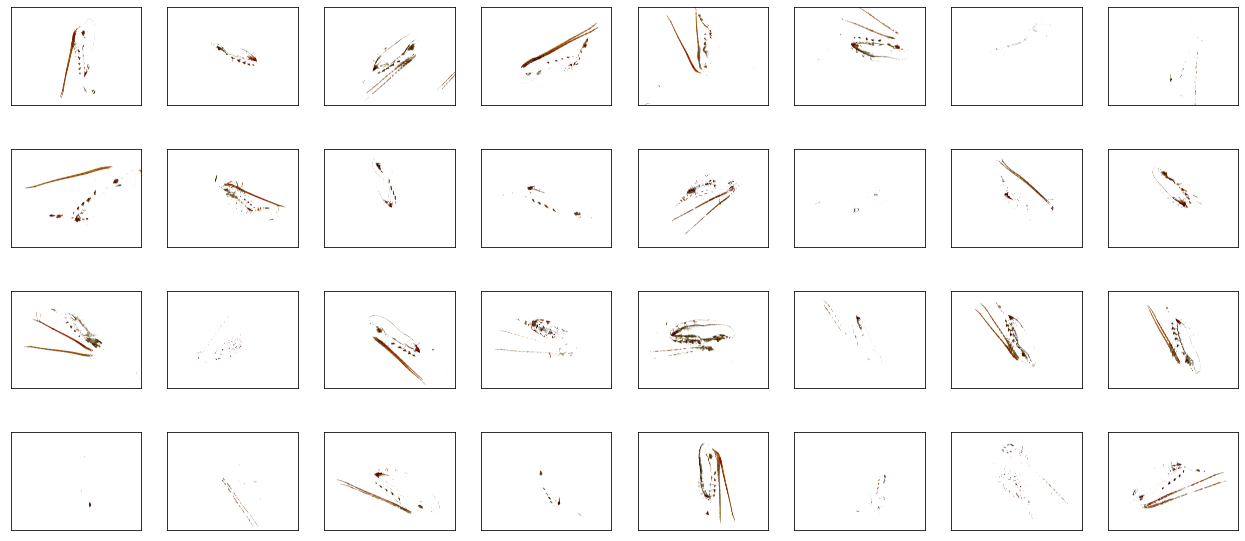

In [365]:
fig = plt.figure(figsize=(22, 10))
columns = 8
rows = 4
j=1
for i in index_sample_list:
    filename_masked = "/home/lvilgrain/complex/ecoplast_clean_dataset/3.Red_pixels_masked/" + imgs_names[i]
    img_masked = io.imread(filename_masked)
    # Plot
    fig.add_subplot(rows, columns, j)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(img_masked)
    j = j+1
plt.show()

ValueError: num must be 1 <= num <= 32, not 33

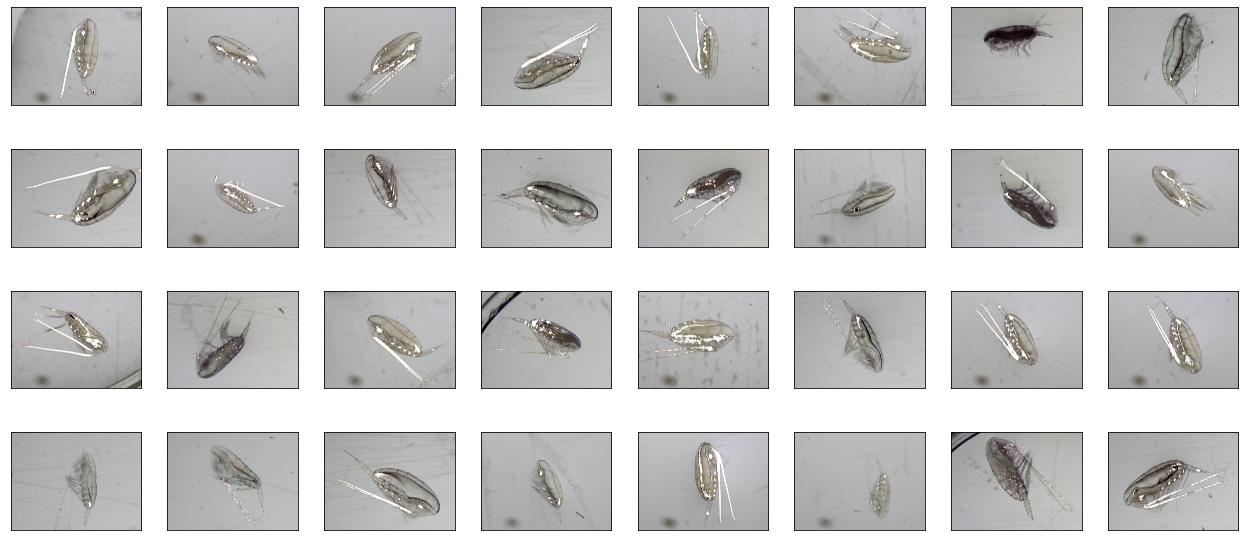

In [366]:
fig = plt.figure(figsize=(22, 10))
columns = 8
rows = 4
j=1
for i in index_sample_list:
    filename_highlighted = "/home/lvilgrain/complex/ecoplast_clean_dataset/4.Red_pixels_highlighted/" + imgs_names[i]
    img_highlighted = io.imread(filename_highlighted)
    # Plot
    fig.add_subplot(rows, columns, j)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(img_highlighted)
    j = j+1
plt.show()

In [ ]:
del red_mask_list
gc.collect()

# Read important files

In [259]:
# Temporary : 
#index_sample_list = [539, 526, 568, 222, 519, 483, 170, 375, 205, 677, 299, 376, 179, 428, 172, 645, 466, 163, 545, 154, 475, 276, 613, 610, 343, 346, 208, 411, 630, 410, 158, 256]

#imgs_names
with open("/home/lvilgrain/complex/ecoplast_clean_dataset/data/imgs_names.txt", "rb") as imgn:   # Unpickling
    imgs_names = pickle.load(imgn)

# imgs_norm_list
with open("/home/lvilgrain/complex/ecoplast_clean_dataset/data/imgs_norm_list.txt", "rb") as imgnrm:   # Unpickling
    imgs_norm_list = pickle.load(imgnrm)

# red_mask_list
with open("/home/lvilgrain/complex/ecoplast_clean_dataset/data/red_mask_list.txt", "rb") as rml:   # Unpickling
    red_mask_list = pickle.load(rml)

## 7. Integrate pixel size

In [30]:
# Create a sample of 32 images based on previous indices randomly chosen
#imgs_sample = [ ]
#for i in index_sample_list:
#    imgs_sample.append(imgs_names[i])

In [260]:
# Check if the threshold of 0.5 is well chosen 
# take all images from imags_norm_list
display(len(imgs_norm_list))
display(imgs_norm_list[1].shape)
# compute total number of items
# randomly take a portion of these items
# print a density distribution of the index 
#Problem :
display(1920*2560)
print("One image contains 4915200 pixels and there are 699 images so", 4915200 * 699, "pixels to analyse for the dataset")

699

(1920, 2560)

4915200

One image contains 4915200 pixels and there are 699 images so 3435724800 pixels to analyse for the dataset


In [262]:
# Find the number of red pixels by image
# Compute the total redness sum by image
pixels_nb_list = [ ]
redness_sum_list = [ ]

for i in range(0, len(imgs_norm_list)):
    img_norm = imgs_norm_list[i]
    # Threshold using intensities histogramm on the image 
    red_mask = red_mask_list[i]
    OD50plus = copy.copy(img_norm)
    OD50plus = OD50plus[red_mask]
    # !!! We divide by 1000 because numbers are too large, and we are interested in relative variations among images 
    pixels_nb_list.append(OD50plus.size)
    redness_sum_list.append(OD50plus.sum())


In [281]:
print("Example of 10 sums of red pixels by image:", pixels_nb_list[0:10])
print("Average sum of red pixels by image:", np.mean(pixels_nb_list[0:10]))
print("---")
print("Example of 10 sums of redness intensity by image:",redness_sum_list[0:10])
print("Average sum of red pixels by image:", np.mean(redness_sum_list[0:10]))

Example of 10 sums of red pixels by image: [86039, 103963, 78547, 25588, 49913, 135084, 32525, 20902, 35519, 79939]
Average sum of red pixels by image: 64801.9
---
Example of 10 sums of redness intensity by image: [50679.26177618931, 67121.32085866631, 47460.11427648665, 14788.046634202317, 28695.240481775603, 86625.58317382797, 19049.305795389966, 11876.097866884522, 21410.29201256594, 54449.391989888005]
Average sum of red pixels by image: 40215.46548658765


In [282]:
# Image total size
img_ex = io.imread("/home/lvilgrain/complex/ecoplast_clean_dataset/1.Original/" + imgs_names[4])
img_length = img_ex.shape[0]
img_width = img_ex.shape[1]
img_pixel_number = img_length*img_width
print('An image is', img_length,'pixels long, and has a total of', img_pixel_number, 'pixels')

# One pixel length
pixel_2018_mm = 1/456
pixel_2018_um = pixel_2018_mm*1000
pixel_area_2018_um2 = (pixel_2018_um)**2

pixel_2019_mm = 1/368
pixel_2019_um = pixel_2019_mm*1000
pixel_area_2019_um2 = (pixel_2019_um)**2

# Pixel pitch
print('The pitch of one pixel in 2018 is', pixel_2018_mm,'mm =', pixel_2018_um, 'μm')
print('The pitch of one pixel in 2019 is', pixel_2019_mm,'mm =', pixel_2019_um, 'μm')

# Pixel area : 
print('The area of one pixel in 2018 is', pixel_area_2018_um2, 'μm^2')
print('The area of one pixel in 2019 is', pixel_area_2019_um2, 'μm^2')

# Image total length
print('the total length of one image is', img_length * pixel_2018_mm, 'mm in 2018')
print('the total length of one image is', img_length * pixel_2019_mm, 'mm in 2019')

An image is 1920 pixels long, and has a total of 4915200 pixels
The pitch of one pixel in 2018 is 0.0021929824561403508 mm = 2.1929824561403506 μm
The pitch of one pixel in 2019 is 0.002717391304347826 mm = 2.717391304347826 μm
The area of one pixel in 2018 is 4.809172052939365 μm^2
The area of one pixel in 2019 is 7.38421550094518 μm^2
the total length of one image is 4.2105263157894735 mm in 2018
the total length of one image is 5.217391304347826 mm in 2019


In [285]:
redness_indices = [ ]

for i in range(0, len(imgs_names)):
    img_name = imgs_names[i]
    redness_intensity = redness_sum_list[i]
    if "2018" in img_name : 
        redness_indices.append(redness_intensity * pixel_area_2018_um2/1000)
    else : 
        redness_indices.append(redness_intensity* pixel_area_2019_um2/1000)


red_ind_final = pd.DataFrame(

    {   "img_name": imgs_names,
        "redness_index": redness_indices,
        "red_pixels_nb" :  pixels_nb_list
    }
)

In [287]:
print("/1000:", np.min(red_ind_final['redness_index']), np.max(red_ind_final['redness_index']))

/1000: 0.6108240229234528 1046.6369348759727


In [288]:
# Save it
red_ind_final.to_csv(path_or_buf="data_emilia/red_ind_final.csv", index=False)

del red_ind_final
gc.collect()

# 7. Histogram of OD value

An image is 1920 pixels high, 2560 pixels long and has a total of 4915200 pixels


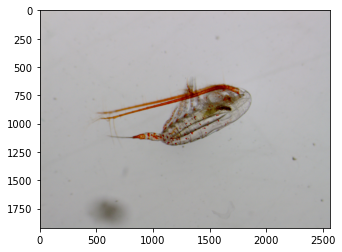

In [339]:
img_ex = io.imread("/home/lvilgrain/complex/ecoplast_clean_dataset/2.Calibrated/" + imgs_names[698])
plt.imshow(img_ex)
img_height = img_ex.shape[0]
img_width = img_ex.shape[1]
print('An image is', img_height,'pixels high,', img_width, 'pixels long and has a total of', img_height*img_width, 'pixels') 

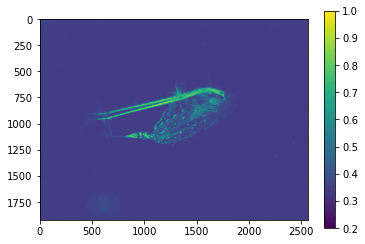

In [341]:
img_ex_norm = imgs_norm_list[698]
plt.imshow(img_ex_norm, vmin=0.2, vmax = 1)
plt.colorbar()   

In [312]:
# We want to represent values inside this list of 699 images: 
print(type(imgs_norm_list), 'of', len(imgs_norm_list), 'images, with', len(imgs_norm_list[1]),'rows and', len(imgs_norm_list[1][1]),'columns.', 'The first value is:', imgs_norm_list[1][1][1])

<class 'list'> of 699 images, with 1920 rows and 2560 columns. The first value is: 0.36370037766443597


In [322]:
imgs_norm_list[1][1]

array([0.37211172, 0.36370038, 0.35451115, ..., 0.35325774, 0.35088467,
       0.34914313])

In [327]:
redness_col_flat = imgs_norm_list[1][1].flatten()

In [332]:
len(redness_col_flat)

2560

In [331]:
len(imgs_norm_list[1][1])

2560

In [333]:
redness_img_flat = imgs_norm_list[1].flatten()

In [335]:
len(redness_img_flat)

4915200

In [337]:
all_img_pixels = []

for i in imgs_norm_list:
    # Flatten the array
    redness_img_flat = i.flatten()
    all_img_pixels.append(redness_img_flat)
len(all_img_pixels)

699

255.4967679977417


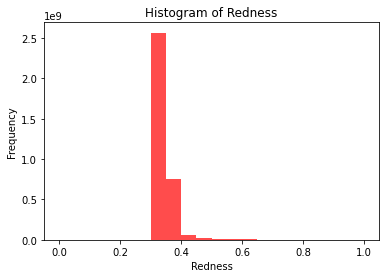

In [359]:
start = time.time()

sample = random.sample(all_img_pixels,699)
sample_arr = np.array(sample)
sample_arr = sample_arr.flatten()

end = time.time()
print(end-start)

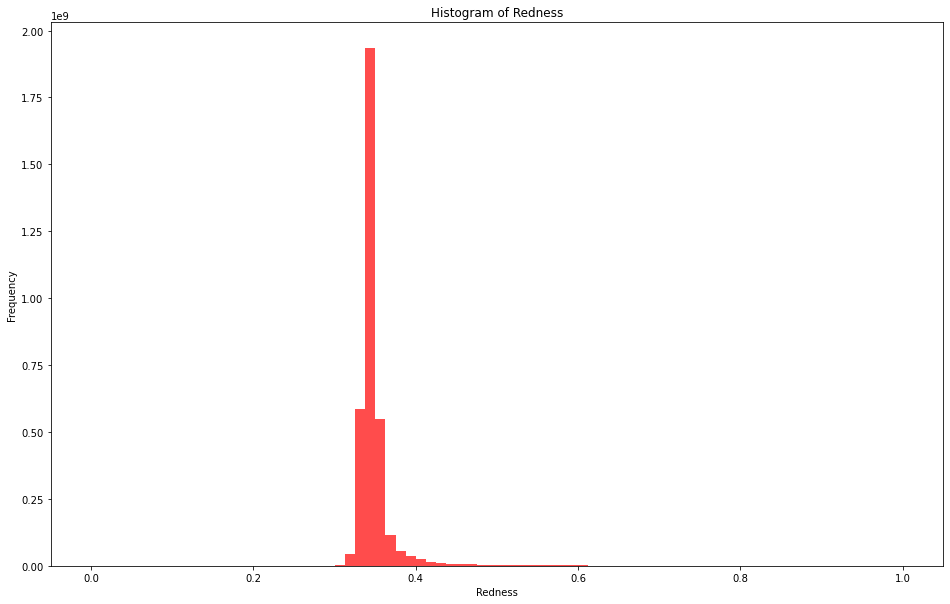

45.168150424957275


In [369]:
fig = plt.figure(figsize=(16, 10))

start2 = time.time()
# Plot the histogram
plt.hist(sample_arr , bins=80, color='red', alpha=0.7)
plt.xlabel('Redness')
plt.ylabel('Frequency')
plt.title('Histogram of Redness')
plt.show()
end2 = time.time()
print(end2-start2)

In [370]:
from skimage.filters import threshold_otsu

thr = threshold_otsu(sample_arr, nbins=80)


In [363]:
print(thr)

0.45


# 8. Graph to illustrate results

### Read the file that identifed 10 images of interest

In [97]:
# Ouvrir le fichier csv
images_letters = pd.read_csv('data_emilia/image_letters.csv', delimiter=";")
print(images_letters)

           image_name image_letter
0    2018_G_p85_5.tif            a
1  2019_ISF_L_B_6.tif            b
2   2018_AR_p22_4.tif            c
3   2019_K_S_A1_9.tif            d
4   2018_AR_p21_5.tif            e
5   2018_AR_p29_7.tif            f
6    2018_G_p86_7.tif            g
7    2018_F_p51_7.tif            h
8    2019_K_G_B_3.tif            i
9   2019_B_S_A2_6.tif            j


### Find indices of those 10 images

In [149]:
samp = []
for i in range(0, len(images_to_show)):
    print(images_letters['image_name'][i])
    samp.append(images_letters['image_name'][i])
print(samp)

2018_G_p85_5.tif
2019_ISF_L_B_6.tif
2018_AR_p22_4.tif
2019_K_S_A1_9.tif
2018_AR_p21_5.tif
2018_AR_p29_7.tif
2018_G_p86_7.tif
2018_F_p51_7.tif
2019_K_G_B_3.tif
2019_B_S_A2_6.tif
['2018_G_p85_5.tif', '2019_ISF_L_B_6.tif', '2018_AR_p22_4.tif', '2019_K_S_A1_9.tif', '2018_AR_p21_5.tif', '2018_AR_p29_7.tif', '2018_G_p86_7.tif', '2018_F_p51_7.tif', '2019_K_G_B_3.tif', '2019_B_S_A2_6.tif']


 Prepare list of indices of image to show in Chapter 3

In [151]:
index_samp = []
for i in samp:
    index = imgs_calib_list.index(i)
    index_samp.append(index)
print(index_samp)

[345, 545, 14, 678, 5, 87, 357, 207, 622, 446]


### Print and save all those 10 images at each step

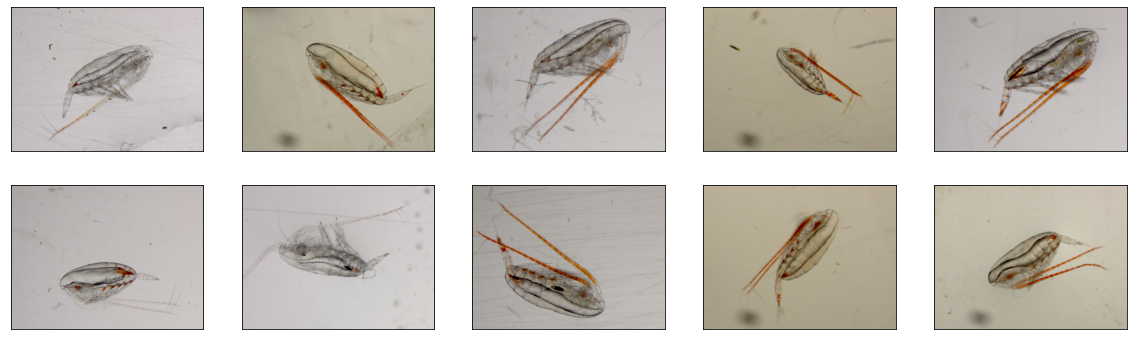

In [250]:
# Original
fig = plt.figure(figsize=(20, 6))
columns = 5
rows = 2
j=1
for i in index_samp: # TODO: add a condition on file types to read (.tiff, .jpg)
    filename = "/home/lvilgrain/complex/ecoplast_clean_dataset/1.Original/" + imgs_names[i]
    img = io.imread(filename)
    io.imsave("/home/lvilgrain/complex/ecoplast_clean_dataset/5.Chap3/" + imgs_names[i] + "_orig.tiff", img)
    fig.add_subplot(rows, columns, j)
    plt.xticks([], [])
    plt.yticks([], [])
    #plt.title(np.around(np.mean(img, axis=(0,1))))
    plt.imshow(img)
    j = j+1
plt.show()

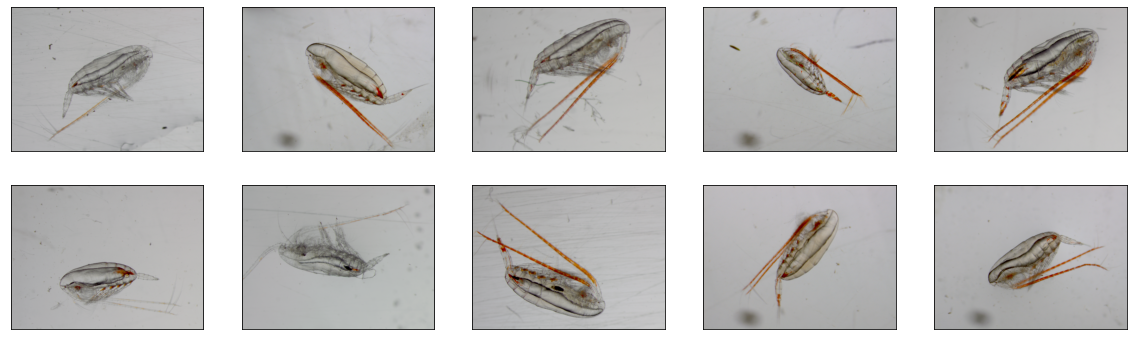

<Figure size 432x288 with 0 Axes>

In [251]:
# Calibrated
fig = plt.figure(figsize=(20, 6))
columns = 5
rows = 2
j=1
for i in index_samp: # TODO: add a condition on file types to read (.tiff, .jpg)
    filename = "/home/lvilgrain/complex/ecoplast_clean_dataset/2.Calibrated/" + imgs_names[i]
    img_calib = io.imread(filename)
    io.imsave("/home/lvilgrain/complex/ecoplast_clean_dataset/5.Chap3/" + imgs_names[i] + "_cal.tiff", img_calib)
    fig.add_subplot(rows, columns, j)
    plt.xticks([], [])
    plt.yticks([], [])
    #plt.title(np.around(np.mean(img_calib, axis=(0,1))))
    plt.imshow(img_calib)
    j = j+1
plt.show()
plt.savefig("results/calib.png")

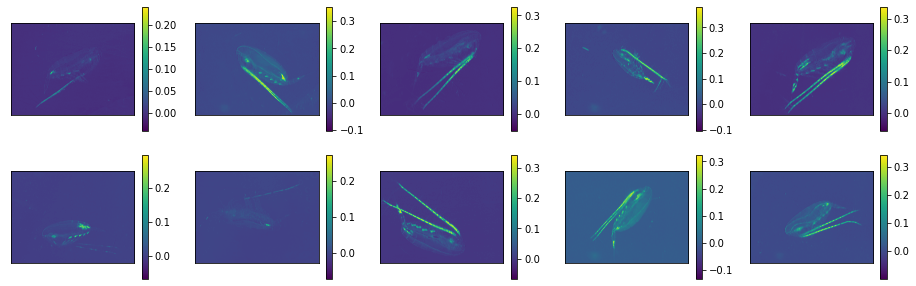

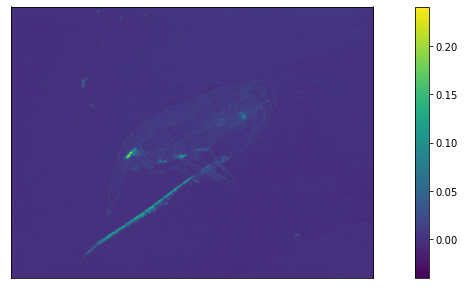

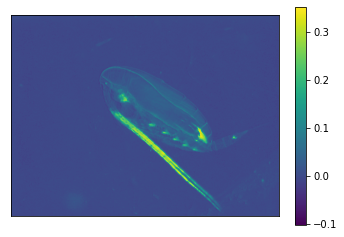

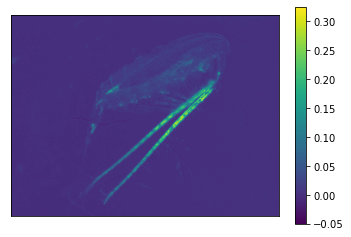

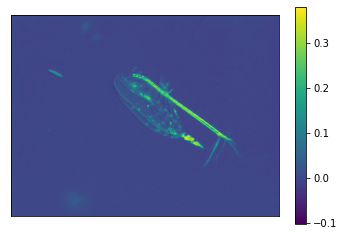

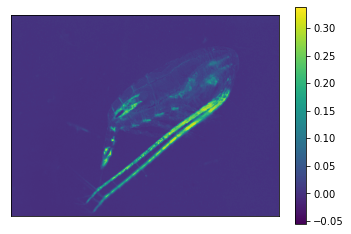

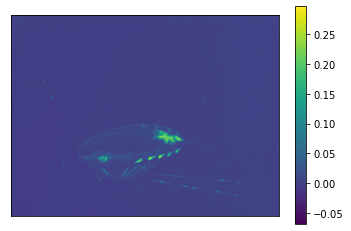

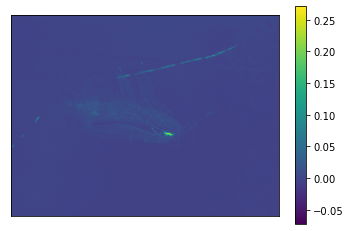

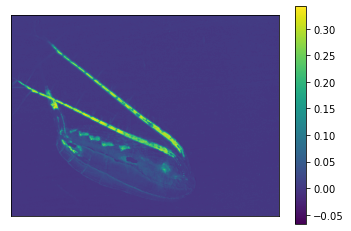

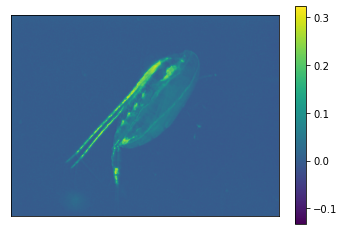

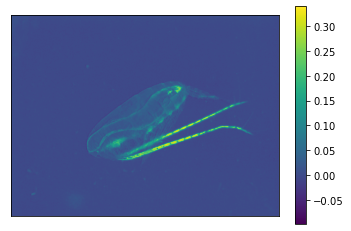

In [225]:
# Raw OD
fig = plt.figure(figsize=(16, 5))
columns = 5
rows = 2
j=1
for i in index_samp:
    #print(i)
    red = asta_OD_imgs_list[i]
    # Plot
    fig.add_subplot(rows, columns, j)
    #plt.title(imgs_names[i])
    plt.xticks([], [])
    plt.yticks([], [])
    low, high = np.quantile(red, (.0, 1))
    plt.imshow(red, vmin=low, vmax = high)
    plt.colorbar()
    j = j+1
plt.show()
plt.close()

# Raw OD
fig = plt.figure(figsize=(15, 5))
columns = 5
rows = 2
j=1
for i in index_samp:
    #print(i)
    red = asta_OD_imgs_list[i]
    #io.imsave("/home/lvilgrain/complex/ecoplast_clean_dataset/5.Chap3/" + imgs_names[i] + "_rawOD.tiff", red)
    # Plot
    plt.xticks([], [])
    plt.yticks([], [])
    low, high = np.quantile(red, (.0, 1))
    plt.imshow(red, vmin=low, vmax = high)
    plt.colorbar()
    plt.savefig("/home/lvilgrain/complex/ecoplast_clean_dataset/5.Chap3/" + imgs_names[i] + "_rawOD.tiff")
    plt.show()
    plt.close()

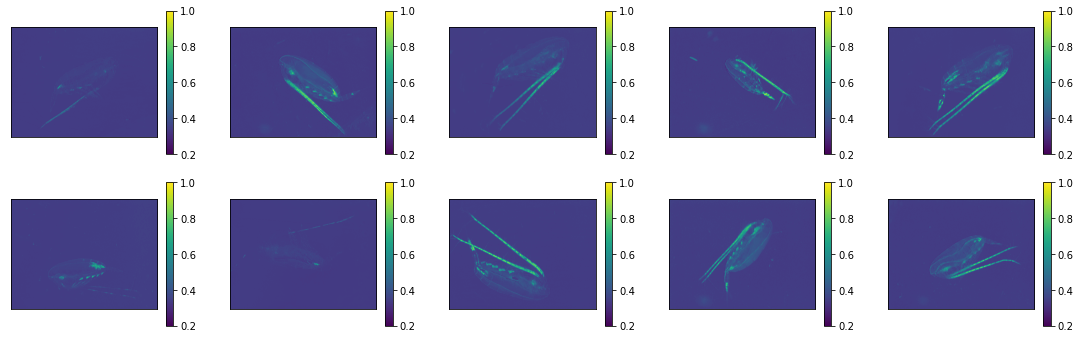

In [256]:
# Normalized OD 
fig = plt.figure(figsize=(19, 5.8))
columns = 5
rows = 2
j=1
for i in index_samp:
    #print(i)
    img_norm = imgs_norm_list[i]
    # Plot
    fig.add_subplot(rows, columns, j)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(img_norm, vmin=0.2, vmax = 1)
    plt.colorbar()
    j = j+1
plt.show()

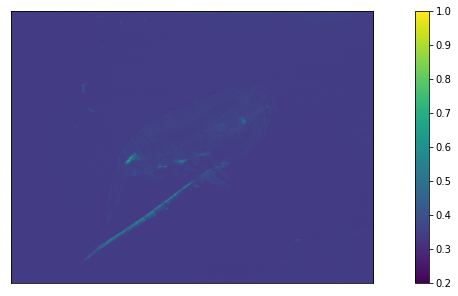

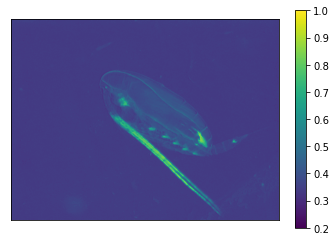

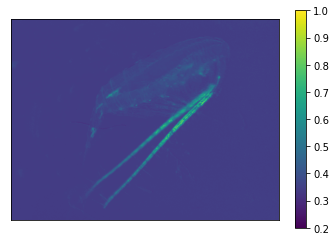

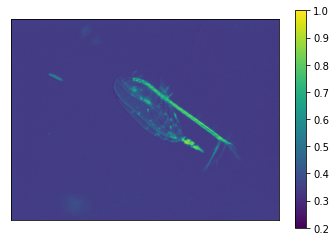

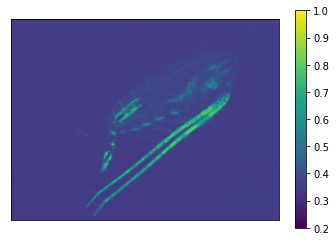

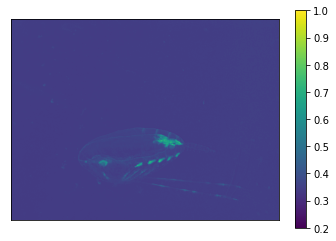

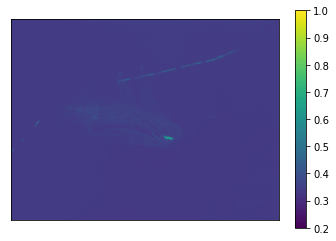

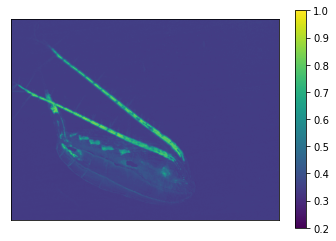

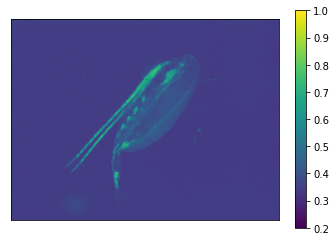

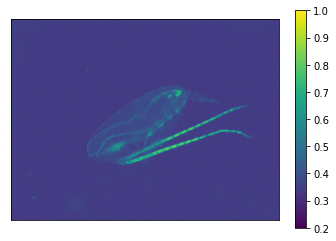

In [223]:
# Norm OD

fig = plt.figure(figsize=(15, 5))
columns = 5
rows = 2
j=1
for i in index_samp:
    #print(i)
    img_norm = imgs_norm_list[i]
    #io.imsave("/home/lvilgrain/complex/ecoplast_clean_dataset/5.Chap3/" + imgs_names[i] + "_rawOD.tiff", red)
    # Plot
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(img_norm, vmin=0.2, vmax = 1)
    plt.colorbar()
    plt.savefig("/home/lvilgrain/complex/ecoplast_clean_dataset/5.Chap3/" + imgs_names[i] + "_normOD.tiff")
    plt.show()
    plt.close()

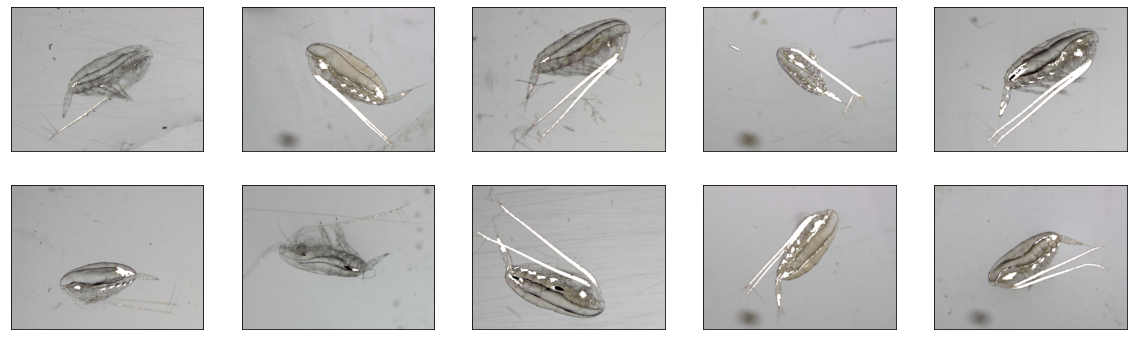

In [367]:
# Red pixels segmented
fig = plt.figure(figsize=(20, 6))
columns = 5
rows = 2
j=1
for i in index_samp:
    filename_highlighted = "/home/lvilgrain/complex/ecoplast_clean_dataset/4.Red_pixels_highlighted/" + imgs_names[i]
    img_highlighted = io.imread(filename_highlighted)
    io.imsave("/home/lvilgrain/complex/ecoplast_clean_dataset/5.Chap3/" + imgs_names[i] + "_high.tiff", img_highlighted)
    # Plot
    fig.add_subplot(rows, columns, j)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(img_highlighted)
    j = j+1
plt.show()

<ipython-input-368-718518140239>:9: UserWarning: /home/lvilgrain/complex/ecoplast_clean_dataset/5.Chap3/2018_G_p85_5.tif_mask.tiff is a low contrast image
  io.imsave("/home/lvilgrain/complex/ecoplast_clean_dataset/5.Chap3/" + imgs_names[i] + "_mask.tiff", img_masked)
<ipython-input-368-718518140239>:9: UserWarning: /home/lvilgrain/complex/ecoplast_clean_dataset/5.Chap3/2018_AR_p29_7.tif_mask.tiff is a low contrast image
  io.imsave("/home/lvilgrain/complex/ecoplast_clean_dataset/5.Chap3/" + imgs_names[i] + "_mask.tiff", img_masked)
<ipython-input-368-718518140239>:9: UserWarning: /home/lvilgrain/complex/ecoplast_clean_dataset/5.Chap3/2018_G_p86_7.tif_mask.tiff is a low contrast image
  io.imsave("/home/lvilgrain/complex/ecoplast_clean_dataset/5.Chap3/" + imgs_names[i] + "_mask.tiff", img_masked)


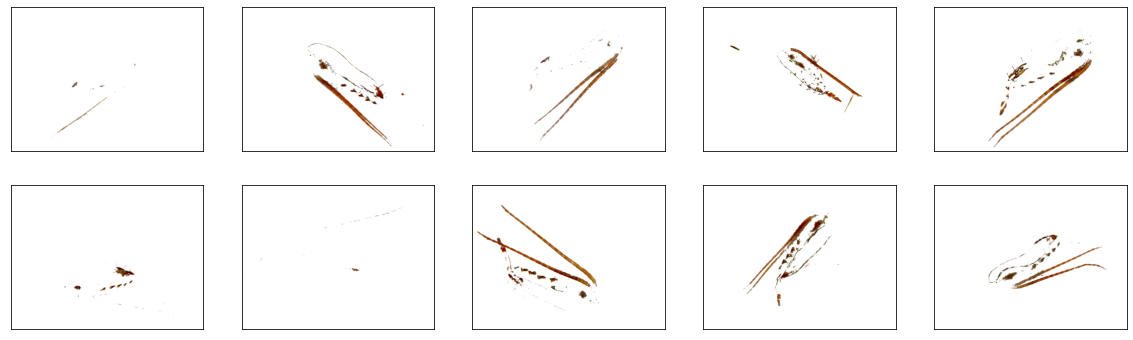

In [368]:
# Red mask
fig = plt.figure(figsize=(20, 6))
columns = 5
rows = 2
j=1
for i in index_samp:
    filename_masked = "/home/lvilgrain/complex/ecoplast_clean_dataset/3.Red_pixels_masked/" + imgs_names[i]
    img_masked = io.imread(filename_masked)
    io.imsave("/home/lvilgrain/complex/ecoplast_clean_dataset/5.Chap3/" + imgs_names[i] + "_mask.tiff", img_masked)
    # Plot
    fig.add_subplot(rows, columns, j)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(img_masked)
    j = j+1
plt.show()

### Histograms of RGB values for Fig 2

In [165]:
img_fig2 = images_letters[images_letters['image_letter'].isin(['h', 'i', 'j'])]

print(img_fig2)

          image_name image_letter
7   2018_F_p51_7.tif            h
8   2019_K_G_B_3.tif            i
9  2019_B_S_A2_6.tif            j


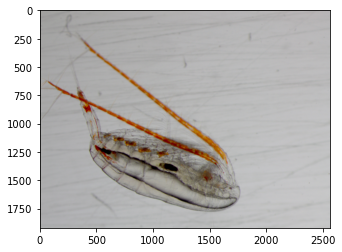

In [220]:
# Plot histogram of RGB values in one image
h_ori_filename = "/home/lvilgrain/complex/ecoplast_clean_dataset/1.Original/2018_F_p51_7.tif"
h_ori = io.imread(h_ori_filename)
plt.imshow(h_ori)

h_cali_filename = "/home/lvilgrain/complex/ecoplast_clean_dataset/2.Calibrated/2018_F_p51_7.tif"
h_cali = io.imread(h_cali_filename)
plt.imshow(h_cali)

In [228]:
plt.figure(figsize=(1.5, 1))
plt.xlim(0,250)
plt.xticks([], [])
plt.yticks([], [])

n, bins, patches = plt.hist(h_ori[:,:,0], 30, facecolor='r', alpha=0.75)
plt.axvline(x = np.around(np.mean(h_ori[:,:,0])), color = 'black')
plt.savefig("/home/lvilgrain/complex/ecoplast_clean_dataset/results/h_ori_RED.png")
plt.close()

plt.figure(figsize=(1.5, 1))
plt.xticks([], [])
plt.yticks([], [])
plt.xlim(0,250)
n, bins, patches = plt.hist(h_ori[:,:,1], 30, facecolor='g', alpha=0.75)
plt.axvline(x = np.around(np.mean(h_ori[:,:,1])), color = 'black')
plt.savefig("/home/lvilgrain/complex/ecoplast_clean_dataset/results/h_ori_GREEN.png")
plt.close()

plt.figure(figsize=(1.5, 1))
plt.xlim(0,250)
plt.xticks([], [])
plt.yticks([], [])
n, bins, patches = plt.hist(h_ori[:,:,2], 30, facecolor='b', alpha=0.75)
plt.axvline(x = np.around(np.mean(h_ori[:,:,2])), color = 'black')
plt.savefig("/home/lvilgrain/complex/ecoplast_clean_dataset/results/h_ori_BLUE.png")
plt.close()

In [227]:
plt.figure(figsize=(1.5, 1))
plt.xlim(0,250)
plt.xticks([], [])
plt.yticks([], [])
n, bins, patches = plt.hist(h_cali[:,:,0], 30, facecolor='r', alpha=0.75)
plt.axvline(x = np.around(np.mean(h_cali[:,:,0])), color = 'black')
plt.savefig("/home/lvilgrain/complex/ecoplast_clean_dataset/results/h_cali_RED.png")
plt.close()

plt.figure(figsize=(1.5, 1))
plt.xlim(0,250)
plt.xticks([], [])
plt.yticks([], [])
n, bins, patches = plt.hist(h_cali[:,:,1], 30, facecolor='g', alpha=0.75)
plt.axvline(x = np.around(np.mean(h_cali[:,:,1])), color = 'black')
plt.savefig("/home/lvilgrain/complex/ecoplast_clean_dataset/results/h_cali_GREEN.png")
plt.close()

plt.figure(figsize=(1.5, 1))
plt.xlim(0,250)
plt.xticks([], [])
plt.yticks([], [])
n, bins, patches = plt.hist(h_cali[:,:,2], 30, facecolor='b', alpha=0.75)
plt.axvline(x = np.around(np.mean(h_cali[:,:,2])), color = 'black')
plt.savefig("/home/lvilgrain/complex/ecoplast_clean_dataset/results/h_cali_BLUE.png")
plt.close()

In [232]:
np.around(np.mean(h_ori[:,:,0])), np.around(np.mean(h_ori[:,:,1])), np.around(np.mean(h_ori[:,:,2]))

(169.0, 162.0, 156.0)

In [233]:
np.around(np.mean(h_cali[:,:,0])), np.around(np.mean(h_cali[:,:,1])), np.around(np.mean(h_cali[:,:,2]))

(173.0, 170.0, 168.0)

In [234]:
np.around(np.mean(i_ori[:,:,0])), np.around(np.mean(i_ori[:,:,1])), np.around(np.mean(i_ori[:,:,2]))

(186.0, 179.0, 160.0)

In [235]:
np.around(np.mean(i_cali[:,:,0])), np.around(np.mean(i_cali[:,:,1])), np.around(np.mean(i_cali[:,:,2]))

(173.0, 171.0, 170.0)

In [257]:
np.around(np.mean(j_ori[:,:,0])), np.around(np.mean(j_ori[:,:,1])), np.around(np.mean(j_ori[:,:,2]))

(173.0, 162.0, 137.0)

In [258]:
np.around(np.mean(j_cali[:,:,0])), np.around(np.mean(j_cali[:,:,1])), np.around(np.mean(j_cali[:,:,2]))

(175.0, 172.0, 171.0)

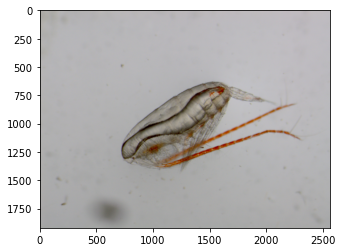

In [238]:
# Plot histogram of RGB values in one image
i_ori_filename = "/home/lvilgrain/complex/ecoplast_clean_dataset/1.Original/2019_B_S_A2_6.tif"
i_ori = io.imread(i_ori_filename)
plt.imshow(i_ori)

i_cali_filename = "/home/lvilgrain/complex/ecoplast_clean_dataset/2.Calibrated/2019_B_S_A2_6.tif"
i_cali = io.imread(i_cali_filename)
plt.imshow(i_cali)


plt.figure(figsize=(1.5, 1))
plt.xlim(0,250)
plt.xticks([], [])
plt.yticks([], [])
n, bins, patches = plt.hist(i_ori[:,:,0], 30, facecolor='r', alpha=0.75)
plt.axvline(x = np.around(np.mean(i_ori[:,:,0])),color = 'black')
plt.savefig("/home/lvilgrain/complex/ecoplast_clean_dataset/results/i_ori_RED.png")
plt.close()

plt.figure(figsize=(1.5, 1))
plt.xlim(0,250)
plt.xticks([], [])
plt.yticks([], [])
n, bins, patches = plt.hist(i_ori[:,:,1], 30, facecolor='g', alpha=0.75)
plt.axvline(x = np.around(np.mean(i_ori[:,:,1])), color = 'black')
plt.savefig("/home/lvilgrain/complex/ecoplast_clean_dataset/results/i_ori_GREEN.png")
plt.close()

plt.figure(figsize=(1.5, 1))
plt.xlim(0,250)
plt.xticks([], [])
plt.yticks([], [])
n, bins, patches = plt.hist(i_ori[:,:,2], 30, facecolor='b', alpha=0.75)
plt.axvline(x = np.around(np.mean(i_ori[:,:,2])), color = 'black')
plt.savefig("/home/lvilgrain/complex/ecoplast_clean_dataset/results/i_ori_BLUE.png")
plt.close()

plt.figure(figsize=(1.5, 1))
plt.xlim(0,250)
plt.xticks([], [])
plt.yticks([], [])
n, bins, patches = plt.hist(i_cali[:,:,0], 30, facecolor='r', alpha=0.75)
plt.axvline(x = np.around(np.mean(i_cali[:,:,0])), color = 'black')
plt.savefig("/home/lvilgrain/complex/ecoplast_clean_dataset/results/i_cali_RED.png")
plt.close()

plt.figure(figsize=(1.5, 1))
plt.xlim(0,250)
plt.xticks([], [])
plt.yticks([], [])
n, bins, patches = plt.hist(i_cali[:,:,1], 30, facecolor='g', alpha=0.75)
plt.axvline(x = np.around(np.mean(i_cali[:,:,1])), color = 'black')
plt.savefig("/home/lvilgrain/complex/ecoplast_clean_dataset/results/i_cali_GREEN.png")
plt.close()

plt.figure(figsize=(1.5, 1))
plt.xlim(0,250)
plt.xticks([], [])
plt.yticks([], [])
n, bins, patches = plt.hist(i_cali[:,:,2], 30, facecolor='b', alpha=0.75)
plt.axvline(x = np.around(np.mean(i_cali[:,:,2])), color = 'black')
plt.savefig("/home/lvilgrain/complex/ecoplast_clean_dataset/results/i_cali_BLUE.png")
plt.close()

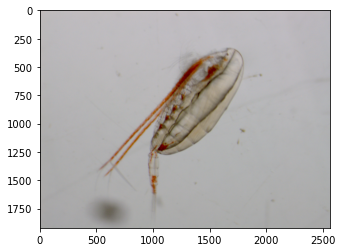

In [231]:
# Plot histogram of RGB values in one image
j_ori_filename = "/home/lvilgrain/complex/ecoplast_clean_dataset/1.Original/2019_K_G_B_3.tif"
j_ori = io.imread(j_ori_filename)

j_cali_filename = "/home/lvilgrain/complex/ecoplast_clean_dataset/2.Calibrated/2019_K_G_B_3.tif"
j_cali = io.imread(j_cali_filename)


plt.figure(figsize=(1.5, 1))
plt.xlim(0,250)
plt.xticks([], [])
plt.yticks([], [])
n, bins, patches = plt.hist(j_ori[:,:,0], 30, facecolor='r', alpha=0.75)
plt.axvline(x = np.around(np.mean(j_ori[:,:,0])), color = 'black')
plt.savefig("/home/lvilgrain/complex/ecoplast_clean_dataset/results/j_ori_RED.png")
plt.close()

plt.figure(figsize=(1.5, 1))
plt.xlim(0,250)
plt.xticks([], [])
plt.yticks([], [])
n, bins, patches = plt.hist(j_ori[:,:,1], 30, facecolor='g', alpha=0.75)
plt.axvline(x = np.around(np.mean(j_ori[:,:,1])), color = 'black')
plt.savefig("/home/lvilgrain/complex/ecoplast_clean_dataset/results/j_ori_GREEN.png")
plt.close()

plt.figure(figsize=(1.5, 1))
plt.xlim(0,250)
plt.xticks([], [])
plt.yticks([], [])
n, bins, patches = plt.hist(j_ori[:,:,2], 30, facecolor='b', alpha=0.75)
plt.axvline(x = np.around(np.mean(j_ori[:,:,2])), color = 'black')
plt.savefig("/home/lvilgrain/complex/ecoplast_clean_dataset/results/j_ori_BLUE.png")
plt.close()

plt.figure(figsize=(1.5, 1))
plt.xlim(0,250)
plt.xticks([], [])
plt.yticks([], [])
n, bins, patches = plt.hist(j_cali[:,:,0], 30, facecolor='r', alpha=0.75)
plt.axvline(x = np.around(np.mean(j_cali[:,:,0])), color = 'black')
plt.savefig("/home/lvilgrain/complex/ecoplast_clean_dataset/results/j_cali_RED.png")
plt.close()

plt.figure(figsize=(1.5, 1))
plt.xlim(0,250)
plt.xticks([], [])
plt.yticks([], [])
n, bins, patches = plt.hist(j_cali[:,:,1], 30, facecolor='g', alpha=0.75)
plt.axvline(x = np.around(np.mean(j_cali[:,:,1])), color = 'black')
plt.savefig("/home/lvilgrain/complex/ecoplast_clean_dataset/results/j_cali_GREEN.png")
plt.close()

plt.figure(figsize=(1.5, 1))
plt.xlim(0,250)
plt.xticks([], [])
plt.yticks([], [])
n, bins, patches = plt.hist(j_cali[:,:,2], 30, facecolor='b', alpha=0.75)
plt.axvline(x = np.around(np.mean(j_cali[:,:,2])), color = 'black')
plt.savefig("/home/lvilgrain/complex/ecoplast_clean_dataset/results/j_cali_BLUE.png")
plt.close()

In [240]:

plt.figure(figsize=(1.5, 1))
plt.xlim(0,250)
plt.xticks([], [])
plt.yticks([], [])
n, bins, patches = plt.hist(h_cali[:,:,2], 30, facecolor='b', alpha=0.75)
plt.axvline(x = np.around(np.mean(h_cali[:,:,2])), color = 'black')
plt.savefig("/home/lvilgrain/complex/ecoplast_clean_dataset/results/h_cali_BLUE.png")
plt.close()

In [241]:

plt.figure(figsize=(1.5, 1))
plt.xlim(0,250)
plt.xticks([], [])
plt.yticks([], [])
n, bins, patches = plt.hist(j_cali[:,:,2], 30, facecolor='b', alpha=0.75)
plt.axvline(x = np.around(np.mean(j_cali[:,:,2])), color = 'black')
plt.savefig("/home/lvilgrain/complex/ecoplast_clean_dataset/results/j_cali_BLUE.png")
plt.close()

In [242]:
plt.figure(figsize=(1.5, 1))
plt.xlim(0,250)
plt.xticks([], [])
plt.yticks([], [])
n, bins, patches = plt.hist(i_cali[:,:,2], 30, facecolor='b', alpha=0.75)
plt.axvline(x = np.around(np.mean(i_cali[:,:,2])), color = 'black')
plt.savefig("/home/lvilgrain/complex/ecoplast_clean_dataset/results/i_cali_BLUE.png")
plt.close()